In [3]:
%cd turnus
%load_ext autoreload
%autoreload 2

[Errno 2] No such file or directory: 'turnus'
/home/dmatis/s/ssd/rl-optimization/turnus


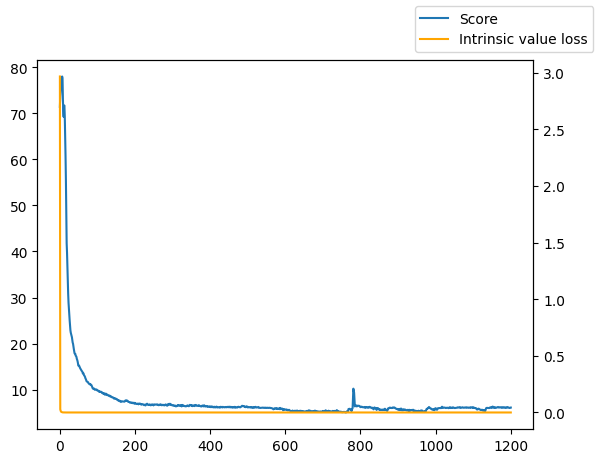

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

training = '240207#p_2_oprava'
df = pd.read_csv(f'results/{training}/score.csv')
df2 = pd.read_csv(f'results/{training}/loss.csv')
fig, ax1 = plt.subplots()

ax1.plot(df['iteration'], df['avg_score'], label='Score')
ax2 = ax1.twinx()

# ax2.plot(df2['iteration'], df2['ext_value'], c='green', label='Extrinsic value loss')
ax2.plot(df2['iteration'], df2['int_value'], c='orange', label='Intrinsic value loss')
fig.legend()

In [19]:
import torch
from env import Env
import utils.graph_utils as graph_utils
from model import GCNPolicy
from utils.utils import reward_to_obj
from torch_geometric.data import Data
import torch.nn.functional as F

def e_greedy_eval(net: torch.nn.Module, env: Env):
    observation, mask = env.reset()
    terminal = False

    r_sum = 0
    while not terminal:
        logit, ext_value, int_value = net(observation)
        logit = torch.where(mask, logit, torch.tensor(-1e+8, device=device))
        probs = F.softmax(logit, dim=-1)
        action = probs.argmax()
        observation, mask, reward, terminal, _ = env.step(action.item())
        r_sum += reward

    transform_rewards = env.reward_to_score_transformer()

    return observation, r_sum, transform_rewards(r_sum)

def search_results(net: torch.nn.Module, env: Env, search_count = 100):
    result_observations = []
    result_rewards = []
    for i in range(search_count):
        observation, mask = env.reset()
        terminal = False

        r_sum = 0
        while not terminal:
            logit, ext_value, int_value = net(observation)
            logit = torch.where(mask, logit, torch.tensor(-1e+8, device=device))
            probs = F.softmax(logit, dim = -1)
            action = probs.multinomial(num_samples = 1)
            observation, mask, reward, terminal, _ = env.step(action.item())
            r_sum += reward

        result_observations.append(observation)
        result_rewards.append(r_sum)

    transform_rewards = env.reward_to_score_transformer()

    return result_observations, result_rewards, list(map(transform_rewards, result_rewards))

# def eval_search_results(observations, rewards, env: Env):

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph, optimal = graph_utils.load_problem('data/2')

env = Env(graph, optimal, device)
net = GCNPolicy(env.state_space(), env.action_space()).to(device)
# net.load_state_dict(torch.load('results/240206#p_2_gcn_continue/models/iter_6.pt'))
net.load_state_dict(torch.load('results/240207#p_2_oprava/models/iter_761.pt'))
# net.train()

# observation, _, vehicles = e_greedy_eval(net, env)
observations, rewards, vehicles = search_results(net, env, 100)
vehicles

[6.0,
 6.0,
 5.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 5.0,
 6.0,
 5.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 5.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 6.0,
 5.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 6.0,
 6.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0]

In [20]:
np.min(vehicles), np.max(vehicles)

(5.0, 6.0)

In [14]:
def get_tours_by_vehicles(graph: Data, env: Env):
    vehicles = {}
    for i in range(graph.num_nodes):
        node = graph.x[i]
        vehicle = (node[env.flag_visited_index] * env.MAX_VEHICLES).round(decimals=5).item()

        if vehicle != int(vehicle):
            raise ValueError(f"Vehicle ID is not an integer. Got {vehicle} for {i}")

        vehicle = int(vehicle)

        if str(vehicle) not in vehicles:
            vehicles[str(vehicle)] = []

        vehicles[str(vehicle)].append(i)

    return vehicles

get_tours_by_vehicles(observation.cpu(), env)

{'0': [0, 78],
 '3': [1, 6, 12, 15, 21, 25, 27, 30, 39, 40, 44, 51, 55, 62, 66, 74, 75],
 '4': [2, 4, 10, 16, 20, 22, 29, 31, 32, 36, 46, 49, 53, 58, 64, 71, 73],
 '1': [3, 8, 11, 17, 19, 23, 28, 34, 42, 45, 50, 57, 59, 61, 69, 70, 72, 77],
 '2': [5, 7, 13, 18, 24, 26, 33, 38, 43, 47, 52, 56, 60, 63, 67, 68, 76],
 '5': [9, 14, 35, 37, 41, 48, 54, 65]}

In [15]:
def get_result_subgraph(graph: Data, env: Env):
    vehicle_tours = get_tours_by_vehicles(graph, env)

    edges = []
    for vehicle, node_ids in vehicle_tours.items():
        if vehicle == '0':
            continue
        
        for i in range(len(node_ids) - 1):
            if i == 0:
                edges.append([vehicle_tours['0'][0], node_ids[0]])
            elif i == len(node_ids) - 2:
                edges.append([node_ids[i+1], vehicle_tours['0'][1]])

            edges.append([node_ids[i], node_ids[i+1]])

    edges = torch.tensor(edges)

    return Data(x=graph.x, edge_index=edges.t().contiguous())

get_result_subgraph(observation.cpu(), env)

Data(x=[79, 7], edge_index=[2, 82])

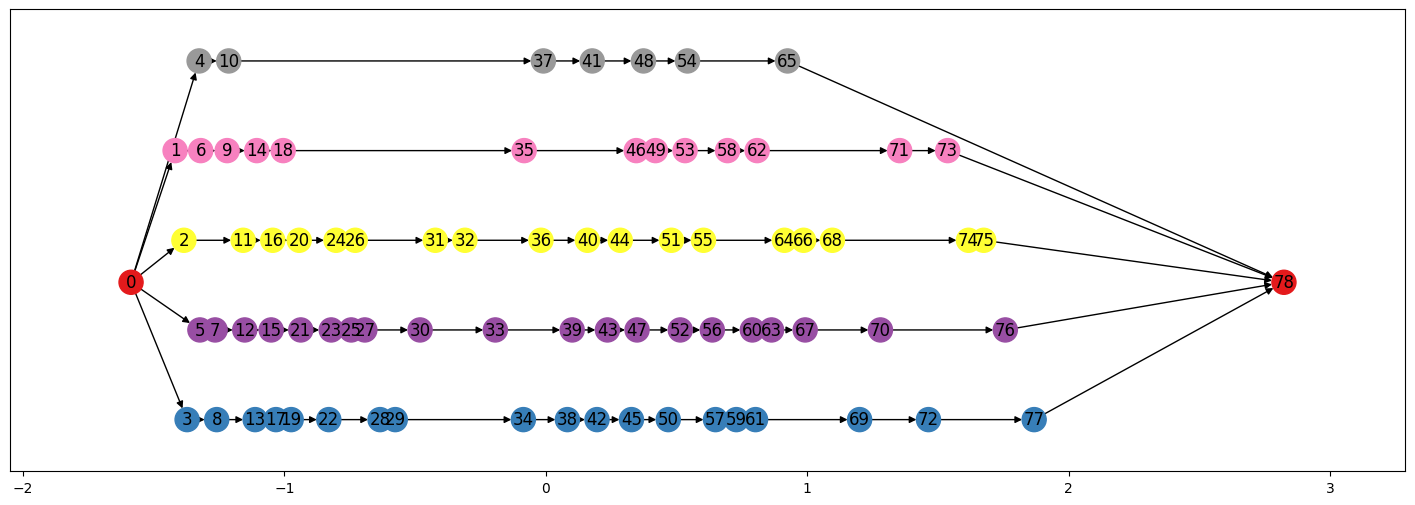

In [22]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import numpy as np

def draw_graph_by_vehicles(graph: Data, env: Env):
    node_labels = graph.x[:, env.flag_visited_index].numpy()
    positions = {}

    center = np.mean(node_labels)

    for i in range(graph.num_nodes):
        node = graph.x[i]
        if node[env.flag_visited_index] == 0:
            positions[i] = [node[2], center]
        else:
            positions[i] = [node[2], node[env.flag_visited_index]]

    g = to_networkx(graph)

    fig, ax = plt.subplots(1, 1, figsize=(18,6))
    nx.draw(g, pos=positions, cmap=plt.get_cmap('Set1'), node_color=node_labels, with_labels=True, ax=ax)
    limits=plt.axis('on')
    ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)

# observation, _, vehicles = e_greedy_eval(net, env)
draw_graph_by_vehicles(get_result_subgraph(observations[3].cpu(), env), env)

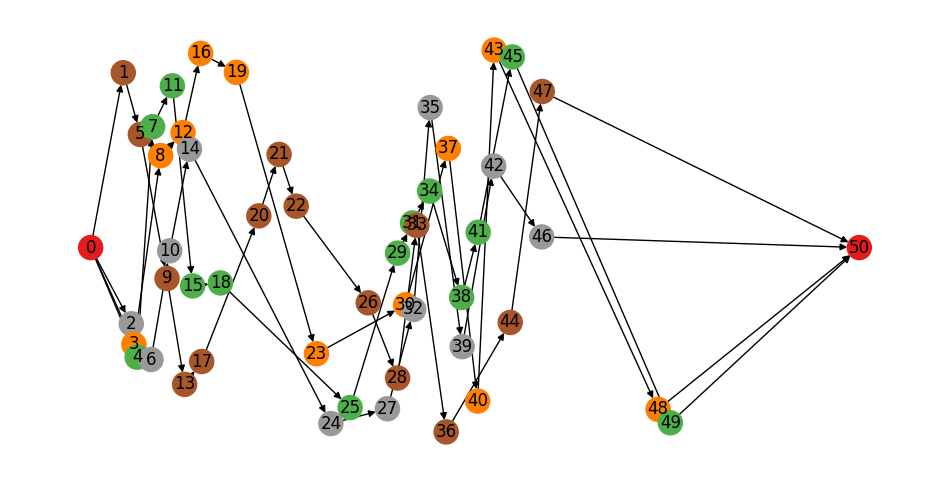

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def draw_graph(graph: Data, env: Env, info=""):
    node_labels = graph.x[:, env.flag_visited_index].numpy()
    positions = {}

    gen = np.random.default_rng(graph.num_nodes)

    mean = graph.x[:, 2].mean()

    for i in range(graph.num_nodes):
        node = graph.x[i]
        if i == 0 or i == graph.num_nodes - 1:
            positions[i] = [node[2].item(), mean]
        else:
            positions[i] = [node[2].item(), mean + (gen.random() - 0.5)]

    g = to_networkx(graph)

    pos = nx.layout.spring_layout(g, pos= positions)
    plt.figure(1,figsize=(12,6))
    plt.text(1, 1, info) 
    nx.draw(g, pos=positions, cmap=plt.get_cmap('Set1'), node_color=node_labels, with_labels=True)

def draw_result(model: str, env: Env):
    observation, _, vehicles = e_greedy_eval(model, env)
    draw_graph(get_result_subgraph(observation.cpu(), env), env, f"Vehicles: {vehicles}")

draw_graph(get_result_subgraph(observation.cpu(), env), env)

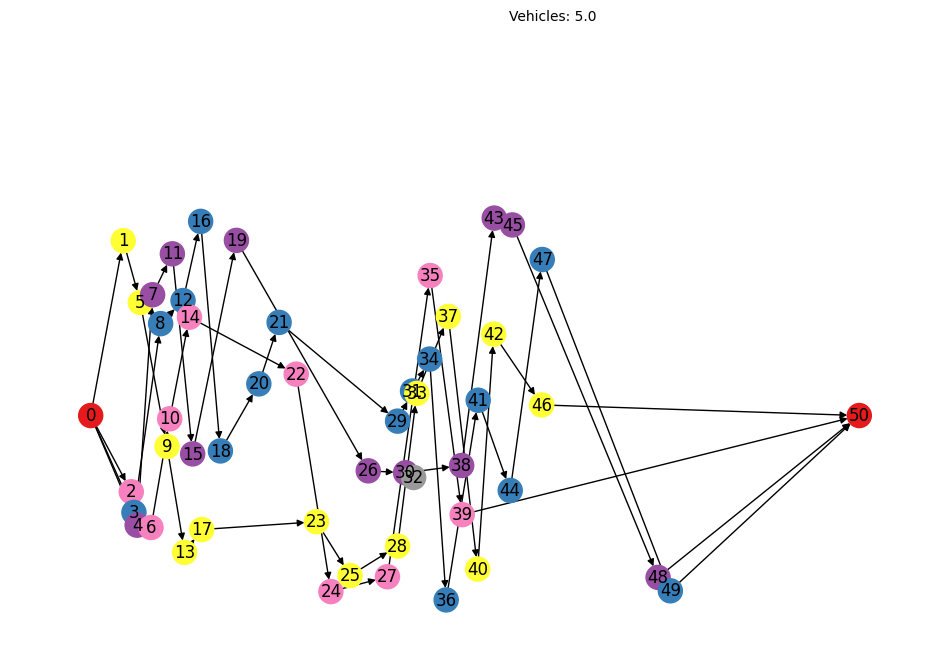

In [14]:
draw_result('results/models/ppo_1021_ppo.pt', env)